In [1]:
def ETMTM(P,D,TB,NT,dt,tag='data',nalphas=20, Poverlap=0.9, win_len=100):
    """
    Extended time multi-taper deconvolution.
    Originally written for Malab by Ved Lekic.
    Translated to Python by Nick Mancinelli.

    For deconvolving S-to-P receiver functions.

    Inputs:
            P
            D
            TB
            NT
            t0
            t1
            dt
            tag

    Returns: RF_Time

    Findings: when P arrival is not in the center of the window, the
    amplitudes are not unity at the beginning and decreasing from there on.
    Instead they peak at the time shift which corresponds to the middle index
    in the P time window.

    As your TB
    increases, the frequency smearing gets worse, which means that the RFs
    degrate at shorter and shorter lag times. Therefore, as you increase TB,
    you should also increase Poverlap.

    TB = 4; NT = 7; %choise of TB = 4, NT = 3 is supposed to be optimal
    t0 = -5; t1 = max(time);
        function [RF_Time] = MTMDecon_VedOptimized(P,D,TB,NT,t0,t1,Faza)
    Ved wrote MTM for MATLAB, which has the added advantage of
    finding the optimal damping parameter.
    TB  = time bandwidth product (usually between 2 and 4)
    NT  = number of tapers to use, has to be <= 2*TB-1
    """

    # Flip time axis in case of Sp
    from numpy import fliplr, round, zeros, concatenate, arange, where
    from numpy import logspace, var, std, median
    from numpy.fft import fft, ifft, fftshift
    from numpy import shape
    from numpy import hanning
    from scipy.interpolate import interp1d
    from nitime.algorithms.spectral import dpss_windows
    from numpy import array, conj, real
    from scipy.signal import convolve
    from numpy import nanmean, nansum
    from numpy import std, argmin, flipud


    D,P = D[::-1], P[::-1]

    # Length of moving time window in seconds
    Nwin = int(round(win_len/dt))
    
    # Fraction of overlap overlap between moving time windows. As your TB
    # increases, the frequency smearing gets worse, which means that the RFs
    # degrate at shorter and shorter lag times. Therefore, as you increase TB,
    # you should also increase Poverlap.
    nso=(1-Poverlap)*Nwin
    nso=int(round(nso))

    npad=zeros(nso)
    D=concatenate((npad,D,npad))
    P=concatenate((P,npad,npad))

    #MATLAB time = 0:dt:dt*(length(P)-1);
    time = arange(0,len(P))*dt
    t1 = max(time)
    t0 = -5

    # Create moving time windows and daughter/parent snippets
    #  MLAB starts = 1:round((1-Poverlap)*Nwin):length(P)-Nwin+1
    tmp=int(round((1-Poverlap)*Nwin))
    starts = range(1,len(P)-Nwin+1,tmp)
    nd=0

    #init tmp_times
    tmp_times=zeros(len(starts)*Nwin).reshape(len(starts),Nwin)
    Dwin=zeros(Nwin*len(starts)).reshape(len(starts),Nwin)

    for j in range(len(starts)):
        tmp_times[j,:(Nwin-1)] = time[starts[j]:starts[j]+Nwin-1]
        if j==0: # ASSUME THAT PARENT PHASE IS CENTERED IN FIRST WINDOW!
            #Pwin = interp1(double(time),double(P),double(tmp_times(j,:)),'linear',0)';
            Pwin = interp1d(time,P)(tmp_times[j,:])


        #print(j, tmp_times[j,:(Nwin-1)][0], tmp_times[j,:(Nwin-1)][-1])
        #print(len(time), len(D), len(tmp_times[j,:]))
        #Dwin(1:Nwin,j) = interp1(double(time),double(D),double(tmp_times(j,:)),'linear',0);
        Dwin[j,:Nwin] = interp1d(time,D)(tmp_times[j,:])

        ltp=win_len/5 # taper before deconvolving (important for synthetics)
        #NICK FIND A TAPER SUBROUTINE TO DEAL WITH NEXT 3 LINES
        #Dwin[1:Nwin,j]=taper(Dwin(1:Nwin,j)',tmp_times(j,1:Nwin),ltp,dt,tmp_times(j,1+round((ltp+dt)/dt)),tmp_times(j,Nwin-round((ltp+dt)/dt)));
        #

        #TheTaper=hanning(ltp*3/dt-2)
        #ind1=round((ltp+dt)/dt)
        #ind2=Nwin-round((ltp+dt)/dt)
        #Dwin[j,ind1:ind2]=Dwin[j,ind1:ind2] * TheTaper

        #from matplotlib import pylab as plt
        #plt.plot(Dwin[ind1:ind2,j])
        #plt.plot(TheTaper)
        #plt.show()

        #nd1=length(find(Dwin(:,j)>1e-2))

        #print '*** Warning no taper!!!'
        #Dwin[:Nwin,j]=taper(Dwin[:Nwin,j],tmp_times[j,:Nwin],ltp,dt,tmp_times[j,1+round((ltp+dt)/dt)],tmp_times[j,Nwin-round((ltp+dt)/dt)])

        nd1=len(where(Dwin[:,j]>1e-2))
        if nd1>nd:
            nd=nd1

    # Search range for optimal damping parameter alpha
    if tag=='data':
        tmpind=len(D)
        alphas = logspace(-2,2,nalphas)*var(D[int(round(tmpind/4)):3*int(round(tmpind/4))])*len(P)
    elif tag =='synth':
        alphas = logspace(-2,2,nalphas)*var(D)*len(P)

    # Figure out average times for each moving window
    t0_times = median(tmp_times,1);

    # Construct Slepians
    #[E,~] = dpss(length(Pwin),TB);

    E,dummy = dpss_windows(len(Pwin),TB,NT)
    E=E


    # Length of waveforms;
    nh = len(Pwin)

    #
    tmpint=shape(tmp_times)[0]

    tmpint2=len(arange(t0,t1+dt,dt))

    RF_Time_win=zeros(tmpint2*tmpint).reshape(tmpint2,tmpint)

    misfit = zeros(len(alphas))
    magntd = zeros(len(alphas))
    # Now, calculate misfit and RF size for each alpha

    for kj in range(len(alphas)):
        # Now loop through different time windows for the daughter component
         #number of elements along axis 0
        for k in range(tmpint): #= 1:size(tmp_times,1)
            # Create multitaper estimates
            for j in range(NT):  #= 1:NT
                tmp1 = fft(E[j,:] *Pwin,nh)
                tmp2 = fft(E[j,:] *Dwin[k,:],nh)
                if j==0:
                    NUM = conj(tmp1) *tmp2
                    DEN = conj(tmp1) *tmp1
                else:
                    NUM = NUM + conj(tmp1) *tmp2
                    DEN = DEN + conj(tmp1) *tmp1

        
            # Calculate optimal RF
            tmp = real(ifft(NUM/(DEN + alphas[kj])))
            
            # Filter and Normalize optimal RF
            nrm = max(real(ifft(DEN/(DEN + alphas[kj]))))
            
            #tmp = reshape(fftshift(tmp./nrm),[1 nh])
            tmp = fftshift(tmp/nrm).reshape(nh)
            
            # Time vector
            
            #vrijeme = dt*[-0.5*(nh-1):1:0.5*(nh-1)]+t0_times(k)-t0_times(1) -dt.*length(npad)
            vrijeme = dt* arange(-0.5*(nh-1),0.5*(nh-1)+1) +t0_times[k]-t0_times[1]-dt*len(npad)
            
            #RF_Time_win(:,k) = interp1(double(vrijeme),double(tmp),double(t0:dt:t1),'linear',NaN);
            RF_Time_win[:,k] = interp1d(vrijeme,tmp,kind='linear',bounds_error=False)(arange(t0,t1+dt,dt))
                                
            #length_Dwin=time(Nwin)-time(0)   

        
        tmp = convolve(nanmean(RF_Time_win,axis=1),P)
        t0d = int(round(t0/dt))        
        
        mfD=D
        
        misfit[kj] = nansum(abs(mfD - tmp[1-t0d:len(D)-t0d+1]))
        magntd[kj] = nansum(abs(tmp[1-t0d:len(D)-t0d]))
    
    # Find optimal alpha
    #[~,j2] = min((misfit./std(misfit)).^2+(magntd./std(magntd)).^2)
    j2 =  argmin((misfit/std(misfit))**2+(magntd/std(magntd))**2)

    # Now loop through different time windows for the daughter component
    for k in range(len(tmp_times[:,0])): #= 1:size(tmp_times,1)
        # Create multitaper estimates
        for j in range(NT): #= 1:NT
            tmp1 = fft(E[j,:]*Pwin,nh)
            tmp2 = fft(E[j,:]*Dwin[k,:],nh)
            if j==0:
                NUM = conj(tmp1)*tmp2;
                DEN = conj(tmp1)*tmp1;
            else:
                NUM = NUM + conj(tmp1)*tmp2
                DEN = DEN + conj(tmp1)*tmp1
        
        # Calculate optimal RF
        tmp = real(ifft(NUM/(DEN + alphas[j2])))
        
        # Filter and Normalize optimal RF
        nrm = max(real(ifft(DEN/(DEN + alphas[j2]))))
        
        tmp = fftshift(tmp/nrm).reshape(nh)
        
        # Time vector
        #vrijeme = dt*[-0.5*(nh-1):1:0.5*(nh-1)]+t0_times(k)-t0_times(1) ...
        #        -dt.*length(npad);
        vrijeme = dt* arange(-0.5*(nh-1),0.5*(nh-1)+1) +t0_times[k]-t0_times[1]-dt*len(npad)
        
        #RF_Time_win(:,k) = interp1(double(vrijeme),double(tmp),double(t0:dt:t1),'linear',0);
        RF_Time_win[:,k] = interp1d(vrijeme,tmp,kind='linear',bounds_error=False)(arange(t0,t1+dt,dt))
    
    RF_Time = nanmean(RF_Time_win,axis=1)
    
    Time = -1*arange(t0,t1+dt,dt)
    
    return Time, RF_Time

def taper(x,time,tpr,dt,t1,t2):
    """ 
        % ********* Function Description *********
        %
        % TAPER  Taper a time series.
        %
        % TAPER(X,TIME,TPR,DT,T1,T2) takes time
        % series sampled at DT and tapers it with
        % a cosine taper TPR seconds long from
        % beginning point T1-TPR and with reverse
        % cosine taper from point T2 to point T2+
        % TPR. Points outside the range (T1-TPR,
        % T2+TPR) are zeroed. If T1/T2 is negative
        % then taper is not implemented at the
        % beginning/end. If X is an array of
        % seismograms, then the taper is applied
        % to each row of X.
        %
        %
        % ****************************************
        % *                                      *
        % *  Modified from Kate Rychert's        *
        % *  receiver function code - May 2008   *
        % *                                      *
        % *  Email: David_Abt@brown.edu          *
        % *                                      *
        % ****************************************
        % Emily, 6th May 2013: problem with start time of phase being <100s, so
        % taper subscripts are negative.
        % Temporary workaround, set taper length to be shorter.
        % N.B. Only one event so far has had this issue!
    """
    from numpy import ones, cos, pi , floor, ceil, arange, zeros
    nn      = len(x)
    nx      = len(x)
    taper   = ones(nn)
    #it  = [0:fix(tpr/dt)]*dt/tpr;
    it      = arange(floor(tpr/dt))*dt/tpr
    ct      = 0.5-0.5*cos(pi*it)
    T1      = floor(time[0]/dt)             # Absolute sample point of first time step
    it1     = floor(t1/dt+1)-T1
    it2     = floor(t2/dt+1)-T1

    if t1>0:
        if it1>floor(tpr/dt):
            taper[(it1-floor(tpr/dt)):it1]	= ct
            taper[:(it1-floor(tpr/dt))]    = zeros(len(arange(it1-floor(tpr/dt))))
        else:
            taper[it1] = ct[floor(tpr/dt)-it1+1:-1]
            taper[0] = 0
            print('Bizarre taper!')

    if t2>0:
        if t2>time[-1]-tpr:
            t2  = time[-1]-tpr
            it2 = floor(t2/dt)-T1

        npts=len(ct[::-1])

        tmp1=it2
        tmp2=it2+npts+1
        #print ct[::-1], npts,tmp1,tmp2,t1,t2
        taper[it2:(it2+npts)] = ct[::-1]

        taper[it2+ceil(tpr/dt):nn]   = zeros(len(taper[it2+floor(tpr/dt):nn]))

    y = zeros(nx);  #modified to 1-D arrays only
    #for ix in range(nx):
        #print 'ix = ', ix, len(y), len(x)
    y[:] = x[:]*taper

In [2]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

#from data_downloader import *

In [3]:
from obspy.clients.fdsn.client import Client

client = Client('IRIS')

network = 'II'
station = 'FFC'

inv = client.get_stations(network=network, station=station,level='response')

sta = inv[0][0]
sta

Station FFC (Flin Flon, Canada)
	Station Code: FFC
	Channel Count: 182/182 (Selected/Total)
	1993-08-28T00:00:00.000000Z - 2599-12-31T23:59:59.000000Z
	Access: open 
	Latitude: 54.73, Longitude: -101.98, Elevation: 338.0 m
	Available Channels:
		FFC..LOG, FFC.00.BHZ (8x), FFC.00.BHN (3x), FFC.00.BHE (3x), 
		FFC.00.BH1 (5x), FFC.00.BH2 (5x), FFC.00.EHZ, FFC.00.EHN, FFC.00.EHE
		FFC.00.ELZ, FFC.00.ELN, FFC.00.ELE, FFC.00.ENZ, FFC.00.EN1, 
		FFC.00.EN2, FFC.00.LCE, FFC.00.LCQ, FFC.00.LDI (2x), FFC.00.LHZ (8x)
		FFC.00.LHN (3x), FFC.00.LHE (3x), FFC.00.LH1 (5x), FFC.00.LH2 (5x)
		FFC.00.LNZ, FFC.00.LN1, FFC.00.LN2, FFC.00.SHZ, FFC.00.SHN, 
		FFC.00.SHE, FFC.00.SLZ, FFC.00.SLN, FFC.00.SLE, FFC.00.VHZ (8x), 
		FFC.00.VHN (3x), FFC.00.VHE (3x), FFC.00.VH1 (5x), FFC.00.VH2 (5x), 
		FFC.00.VMZ (3x), FFC.00.VMN, FFC.00.VME, FFC.00.VM1 (2x), 
		FFC.00.VM2 (2x), FFC.10.BHZ (5x), FFC.10.BH1 (5x), FFC.10.BH2 (5x), 
		FFC.10.LCE, FFC.10.LCQ, FFC.10.LDI, FFC.10.LHZ (5x), FFC.10.LH1 (5x)
		FFC.10.LH2 

In [4]:
import wget

years = range(6,18)

months  = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

for year in years:
    for month in months:
        url='http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/20%02d/%s%02d.ndk' % (year, month, year)
        print(url)
        wget.download( url )

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jan06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/feb06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/mar06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/apr06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/may06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jun06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jul06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/aug06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/sep06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/oct06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/nov06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/dec06.ndk
http

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/apr14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/may14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jun14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jul14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/aug14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/sep14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/oct14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/nov14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/dec14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/jan15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/feb15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/mar15.ndk
http

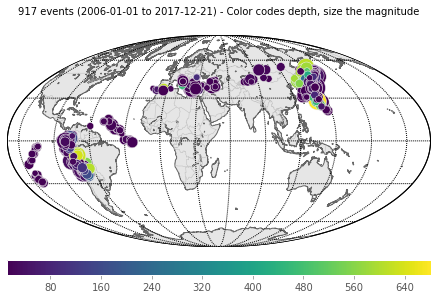

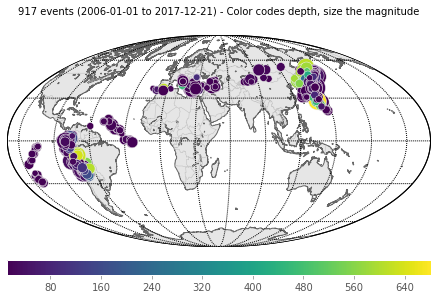

In [5]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = obspy.core.event.Catalog()

for year in years:
    for month in months:
        tmp = obspy.read_events('%s%02d.ndk' % (month, year))
        cat = cat + tmp.filter('magnitude >= 5.5')
    
    
cat2 = obspy.core.event.Catalog()

for evt in cat:
    elat=evt.origins[0].latitude
    elon=evt.origins[0].longitude
    slat=sta.latitude
    slon=sta.longitude
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg=delm/1000/111.11
    if deldeg > 55 and deldeg < 85:
        cat2.append(evt)
        
cat2.plot()
    

In [24]:
from scipy.signal import tukey
from numpy import arange, linspace, zeros
from numpy.random import randn
from numpy import argmax, nan
import warnings
warnings.filterwarnings('ignore')

model = TauPyModel(model="iasp91")

#tries = linspace(0.5, 0.90, 5)
pctage=0.80

#tshifts = [-6, -3, 0, 3, 6]
tshifts = [0]

rbin    = zeros(len(tshifts)*len(cat2)*700).reshape(len(tshifts),len(cat2),700) * nan
rbin_s  = rbin.copy()
mbin1   = zeros(len(tshifts)*len(cat2)).reshape(len(tshifts),len(cat2)) * nan
mbin1_s = mbin1.copy()
mbin2   = mbin1.copy()
mbin2_s = mbin1.copy()

for ievt in range(len(cat2)):
    print('Working on %5d of %5d' % (ievt+1,len(cat2)))

    strike=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
    dip=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
    rake=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake

    quake_depth_in_km=cat2[ievt].preferred_origin().depth/1000.0
    
    etime = cat2[ievt].preferred_origin().time

    slat=sta.latitude
    slon=sta.longitude
    elat=cat2[ievt].preferred_origin().latitude
    elon=cat2[ievt].preferred_origin().longitude

    client_syn = Client()
    
    t1=etime
    t2=etime+3600./2.

    for wvfrm_type in ['data','synthetic']:
    
        if wvfrm_type == 'synthetic':
            tmpstr = '%8.1f %8.1f %6.1f %8.1f %8.1f %8.2f %8.2f %8.2f ' % (elat, elon, quake_depth_in_km, slat, slon, strike, dip, rake)
            print(tmpstr)
            stis = client_syn.get_waveforms(model="iasp91_2s",
                                              sourcelatitude=elat,
                                              sourcelongitude=elon,
                                              sourcedepthinmeters=1000.*quake_depth_in_km,
                                              receiverlatitude=slat, receiverlongitude=slon,
                                              sourcedoublecouple=[strike,dip,rake],
                                              origintime=etime,
                                              units='velocity', starttime=t1, endtime=t2)
        else:
            #
            try:
                stis=client.get_waveforms(network,station,'10','LH?',t1,t2,attach_response=True)
            except:
                print('  get_waveforms failed.')
                break

            pre_filt = (0.005, 0.01, 5.0, 10.0)
            stis.remove_response(output='VEL', pre_filt=pre_filt)
            #


        print(stis)

        #print('...strike, dip, rake, elat, elon, quake_depth_in_km = %3d %3d %3d %5d %5d %5d %5d' % (strike, dip, rake, elat, elon, slat, quake_depth_in_km))


        delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
        deldeg=delm/1000/111.11

        arrivals = model.get_travel_times(source_depth_in_km=quake_depth_in_km, distance_in_degree=deldeg,phase_list=['S'])

        stis.rotate('->ZNE',inventory=inv)
        #stis.rotate('NE->RT', back_azimuth = baz)
        stis.rotate('ZNE->LQT', inclination=arrivals[0].incident_angle, back_azimuth = baz)
        stis.detrend()

        stis.filter('bandpass', freqmin = 1./100., freqmax = 1./8., zerophase=True)
        #stis.filter('highpass', freq=1./20., zerophase=True)
        stis.resample(5)
        stis.differentiate()

        t1=etime+arrivals[0].time - 50
        t2=etime+arrivals[0].time + 50

        for ii, tshift in enumerate(tshifts):

            stis2=stis.copy().trim(t1+tshift,t2+tshift)

            dt = stis2[0].stats.delta

            assert 'L' in stis2[0].stats.channel
            assert 'Q' in stis2[1].stats.channel
            assert 'T' in stis2[2].stats.channel
            
            

            P = stis2[1].copy().data
            D = stis2[0].copy().data

            #Indeces to mask out
            i1 = int(len(P) * (pctage)/2)
            i2 = int(len(P) - i1)
            
            N1=P.copy()[:i1]
            N2=D.copy()[:i1]

            P[:i1]=0.0
            P[i2:]=0.0
            P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))

            smax  = max(abs(P))
            nmax1 = max(abs(N1))
            nmax2 = max(abs(N2))
            #print(i1,i2,imax)
            
            TB = 1.5
            NT = 2

            Poverlap = 0.99
            win_len  = 100

            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
            times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
            _, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

            if wvfrm_type == 'synthetic':
                rbin_s[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1_s[ii,ievt] = smax/nmax1
                mbin2_s[ii,ievt] = smax/nmax2
            else:
                rbin[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1[ii,ievt] = smax/nmax1
                mbin2[ii,ievt] = smax/nmax2
        
from numpy import save
save('array_dump',rbin)
save('max_dump',mbin)

Working on     1 of   917
  get_waveforms failed.
Working on     2 of   917
  get_waveforms failed.
Working on     3 of   917
  get_waveforms failed.
Working on     4 of   917
  get_waveforms failed.
Working on     5 of   917
  get_waveforms failed.
Working on     6 of   917
  get_waveforms failed.
Working on     7 of   917
  get_waveforms failed.
Working on     8 of   917
  get_waveforms failed.
Working on     9 of   917
  get_waveforms failed.
Working on    10 of   917
  get_waveforms failed.
Working on    11 of   917
  get_waveforms failed.
Working on    12 of   917
  get_waveforms failed.
Working on    13 of   917
  get_waveforms failed.
Working on    14 of   917
  get_waveforms failed.
Working on    15 of   917
  get_waveforms failed.
Working on    16 of   917
  get_waveforms failed.
Working on    17 of   917
  get_waveforms failed.
Working on    18 of   917
  get_waveforms failed.
Working on    19 of   917
  get_waveforms failed.
Working on    20 of   917
  get_waveforms failed.


  get_waveforms failed.
Working on   166 of   917
  get_waveforms failed.
Working on   167 of   917
  get_waveforms failed.
Working on   168 of   917
  get_waveforms failed.
Working on   169 of   917
  get_waveforms failed.
Working on   170 of   917
  get_waveforms failed.
Working on   171 of   917
  get_waveforms failed.
Working on   172 of   917
  get_waveforms failed.
Working on   173 of   917
  get_waveforms failed.
Working on   174 of   917
  get_waveforms failed.
Working on   175 of   917
  get_waveforms failed.
Working on   176 of   917
  get_waveforms failed.
Working on   177 of   917
  get_waveforms failed.
Working on   178 of   917
  get_waveforms failed.
Working on   179 of   917
  get_waveforms failed.
Working on   180 of   917
  get_waveforms failed.
Working on   181 of   917
  get_waveforms failed.
Working on   182 of   917
  get_waveforms failed.
Working on   183 of   917
  get_waveforms failed.
Working on   184 of   917
  get_waveforms failed.
Working on   185 of   917


3 Trace(s) in Stream:
II.FFC.10.LH1 | 2009-09-17T23:21:46.069500Z - 2009-09-17T23:51:45.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2009-09-17T23:21:46.069500Z - 2009-09-17T23:51:45.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2009-09-17T23:21:46.069500Z - 2009-09-17T23:51:45.069500Z | 1.0 Hz, 1800 samples
   -29.2   -112.4   12.7     54.7   -102.0   115.00    86.00  -177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-09-17T23:43:52.500000Z - 2009-09-17T23:45:32.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-09-17T23:43:52.500000Z - 2009-09-17T23:45:32.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-09-17T23:43:52.500000Z - 2009-09-17T23:45:32.400000Z | 10.0 Hz, 1000 samples
Working on   263 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2009-09-30T19:03:23.069500Z - 2009-09-30T19:33:22.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2009-09-30T19:03:23.069500Z - 2009-09-30T19:33:22.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2009-09-30T19:03:23.069500Z - 2009-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-12-12T18:55:48.600000Z - 2009-12-12T18:57:28.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-12-12T18:55:48.600000Z - 2009-12-12T18:57:28.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-12-12T18:55:48.600000Z - 2009-12-12T18:57:28.500000Z | 10.0 Hz, 1000 samples
Working on   274 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2009-12-17T01:37:53.069500Z - 2009-12-17T02:07:52.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2009-12-17T01:37:53.069500Z - 2009-12-17T02:07:52.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2009-12-17T01:37:53.069500Z - 2009-12-17T02:07:52.069500Z | 1.0 Hz, 1800 samples
    36.5     -9.9   47.6     54.7   -102.0   316.00    35.00  -170.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-12-17T01:55:43.200000Z - 2009-12-17T01:57:23.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-12-17T01:55:43.200000Z - 2009-12-17T01:57:23.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-12-17T01:55:43.200000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2010-02-27T19:54:35.069500Z - 2010-02-27T20:24:34.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2010-02-27T19:54:35.069500Z - 2010-02-27T20:24:34.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2010-02-27T19:54:35.069500Z - 2010-02-27T20:24:34.069500Z | 1.0 Hz, 1800 samples
    10.8    -43.4   14.0     54.7   -102.0   272.00    57.00   162.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-02-27T20:12:46.200000Z - 2010-02-27T20:14:26.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-02-27T20:12:46.200000Z - 2010-02-27T20:14:26.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-02-27T20:12:46.200000Z - 2010-02-27T20:14:26.100000Z | 10.0 Hz, 1000 samples
Working on   286 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2010-03-04T22:39:30.069500Z - 2010-03-04T23:09:29.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2010-03-04T22:39:30.069500Z - 2010-03-04T23:09:29.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2010-03-04T22:39:30.069500Z - 2010-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-04-11T22:25:01.800000Z - 2010-04-11T22:26:41.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-04-11T22:25:01.800000Z - 2010-04-11T22:26:41.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-04-11T22:25:01.800000Z - 2010-04-11T22:26:41.700000Z | 10.0 Hz, 1000 samples
Working on   297 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2010-04-15T20:52:37.069500Z - 2010-04-15T21:22:36.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2010-04-15T20:52:37.069500Z - 2010-04-15T21:22:36.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2010-04-15T20:52:37.069500Z - 2010-04-15T21:22:36.069500Z | 1.0 Hz, 1800 samples
   -13.4   -112.2   19.3     54.7   -102.0   103.00    87.00    -3.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-04-15T21:11:49.100000Z - 2010-04-15T21:13:29.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-04-15T21:11:49.100000Z - 2010-04-15T21:13:29.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-04-15T21:11:49.100000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2010-07-04T06:57:45.069500Z - 2010-07-04T07:27:44.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2010-07-04T06:57:45.069500Z - 2010-07-04T07:27:44.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2010-07-04T06:57:45.069500Z - 2010-07-04T07:27:44.069500Z | 1.0 Hz, 1800 samples
    -8.7    -80.8   12.0     54.7   -102.0   333.00    18.00    85.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-07-04T07:16:25.900000Z - 2010-07-04T07:18:05.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-07-04T07:16:25.900000Z - 2010-07-04T07:18:05.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-07-04T07:16:25.900000Z - 2010-07-04T07:18:05.800000Z | 10.0 Hz, 1000 samples
Working on   309 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2010-07-04T21:55:56.069500Z - 2010-07-04T22:25:55.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2010-07-04T21:55:56.069500Z - 2010-07-04T22:25:55.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2010-07-04T21:55:56.069500Z - 2010-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-09-22T08:19:54.800000Z - 2010-09-22T08:21:34.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-09-22T08:19:54.800000Z - 2010-09-22T08:21:34.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-09-22T08:19:54.800000Z - 2010-09-22T08:21:34.700000Z | 10.0 Hz, 1000 samples
Working on   320 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2010-10-14T13:58:59.069500Z - 2010-10-14T14:28:58.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2010-10-14T13:58:59.069500Z - 2010-10-14T14:28:58.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2010-10-14T13:58:59.069500Z - 2010-10-14T14:28:58.069500Z | 1.0 Hz, 1800 samples
    42.1    143.2   62.5     54.7   -102.0   236.00    33.00   118.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-10-14T14:18:03.800000Z - 2010-10-14T14:19:43.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-10-14T14:18:03.800000Z - 2010-10-14T14:19:43.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-10-14T14:18:03.800000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-01-10T10:24:23.069500Z - 2011-01-10T10:54:22.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-01-10T10:24:23.069500Z - 2011-01-10T10:54:22.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-01-10T10:24:23.069500Z - 2011-01-10T10:54:22.069500Z | 1.0 Hz, 1800 samples
    23.2    143.1   91.6     54.7   -102.0    17.00    47.00    18.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-01-10T10:46:14.700000Z - 2011-01-10T10:47:54.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-01-10T10:46:14.700000Z - 2011-01-10T10:47:54.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-01-10T10:46:14.700000Z - 2011-01-10T10:47:54.600000Z | 10.0 Hz, 1000 samples
Working on   332 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-01-12T21:32:59.069500Z - 2011-01-12T22:02:58.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-01-12T21:32:59.069500Z - 2011-01-12T22:02:58.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-01-12T21:32:59.069500Z - 2011-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-10T08:28:11.100000Z - 2011-03-10T08:29:51.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-10T08:28:11.100000Z - 2011-03-10T08:29:51.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-10T08:28:11.100000Z - 2011-03-10T08:29:51.000000Z | 10.0 Hz, 1000 samples
Working on   343 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-11T05:47:33.069500Z - 2011-03-11T06:17:32.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-11T05:47:33.069500Z - 2011-03-11T06:17:32.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-11T05:47:33.069500Z - 2011-03-11T06:17:32.069500Z | 1.0 Hz, 1800 samples
    37.5    143.1   20.0     54.7   -102.0   203.00    10.00    88.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-11T06:07:32.600000Z - 2011-03-11T06:09:12.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-11T06:07:32.600000Z - 2011-03-11T06:09:12.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-11T06:07:32.600000Z 

Working on   354 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-12T04:53:01.069500Z - 2011-03-12T05:23:00.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-12T04:53:01.069500Z - 2011-03-12T05:23:00.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-12T04:53:01.069500Z - 2011-03-12T05:23:00.069500Z | 1.0 Hz, 1800 samples
    40.1    143.5   28.7     54.7   -102.0   183.00    22.00    73.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-12T05:12:30.900000Z - 2011-03-12T05:14:10.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-12T05:12:30.900000Z - 2011-03-12T05:14:10.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-12T05:12:30.900000Z - 2011-03-12T05:14:10.800000Z | 10.0 Hz, 1000 samples
Working on   355 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-12T10:53:33.069500Z - 2011-03-12T11:23:32.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-12T10:53:33.069500Z - 2011-03-12T11:23:32.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-12

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-13T08:16:23.000000Z - 2011-03-13T08:18:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-13T08:16:23.000000Z - 2011-03-13T08:18:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-13T08:16:23.000000Z - 2011-03-13T08:18:02.900000Z | 10.0 Hz, 1000 samples
Working on   366 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-13T09:52:34.069500Z - 2011-03-13T10:22:33.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-13T09:52:34.069500Z - 2011-03-13T10:22:33.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-13T09:52:34.069500Z - 2011-03-13T10:22:33.069500Z | 1.0 Hz, 1800 samples
    38.9    142.2   50.0     54.7   -102.0   180.00    28.00    71.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-13T10:12:17.900000Z - 2011-03-13T10:13:57.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-13T10:12:17.900000Z - 2011-03-13T10:13:57.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-13T10:12:17.900000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-16T03:52:06.069500Z - 2011-03-16T04:22:05.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-16T03:52:06.069500Z - 2011-03-16T04:22:05.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-16T03:52:06.069500Z - 2011-03-16T04:22:05.069500Z | 1.0 Hz, 1800 samples
    35.8    140.8   12.0     54.7   -102.0   354.00    34.00   -94.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-16T04:12:34.700000Z - 2011-03-16T04:14:14.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-16T04:12:34.700000Z - 2011-03-16T04:14:14.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-16T04:12:34.700000Z - 2011-03-16T04:14:14.600000Z | 10.0 Hz, 1000 samples
Working on   378 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-16T06:29:07.069500Z - 2011-03-16T06:59:06.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-16T06:29:07.069500Z - 2011-03-16T06:59:06.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-16T06:29:07.069500Z - 2011-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-22T03:59:10.100000Z - 2011-03-22T04:00:50.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-22T03:59:10.100000Z - 2011-03-22T04:00:50.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-22T03:59:10.100000Z - 2011-03-22T04:00:50.000000Z | 10.0 Hz, 1000 samples
Working on   389 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-22T07:18:52.069500Z - 2011-03-22T07:48:51.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-22T07:18:52.069500Z - 2011-03-22T07:48:51.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-22T07:18:52.069500Z - 2011-03-22T07:48:51.069500Z | 1.0 Hz, 1800 samples
    37.1    144.0   12.3     54.7   -102.0    49.00    38.00   -74.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-22T07:38:52.600000Z - 2011-03-22T07:40:32.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-22T07:38:52.600000Z - 2011-03-22T07:40:32.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-22T07:38:52.600000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-27T22:24:02.069500Z - 2011-03-27T22:54:01.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-27T22:24:02.069500Z - 2011-03-27T22:54:01.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-27T22:24:02.069500Z - 2011-03-27T22:54:01.069500Z | 1.0 Hz, 1800 samples
    38.4    142.1   21.7     54.7   -102.0   123.00    28.00   -62.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-27T22:43:57.600000Z - 2011-03-27T22:45:37.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-27T22:43:57.600000Z - 2011-03-27T22:45:37.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-27T22:43:57.600000Z - 2011-03-27T22:45:37.500000Z | 10.0 Hz, 1000 samples
Working on   401 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-03-29T10:54:36.069500Z - 2011-03-29T11:24:35.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-03-29T10:54:36.069500Z - 2011-03-29T11:24:35.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-03-29T10:54:36.069500Z - 2011-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-04-11T23:28:51.200000Z - 2011-04-11T23:30:31.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-04-11T23:28:51.200000Z - 2011-04-11T23:30:31.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-04-11T23:28:51.200000Z - 2011-04-11T23:30:31.100000Z | 10.0 Hz, 1000 samples
Working on   412 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-04-12T05:07:46.069500Z - 2011-04-12T05:37:45.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-04-12T05:07:46.069500Z - 2011-04-12T05:37:45.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-04-12T05:07:46.069500Z - 2011-04-12T05:37:45.069500Z | 1.0 Hz, 1800 samples
    37.1    140.6   18.5     54.7   -102.0   170.00    53.00    12.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-04-12T05:28:01.700000Z - 2011-04-12T05:29:41.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-04-12T05:28:01.700000Z - 2011-04-12T05:29:41.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-04-12T05:28:01.700000Z 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-05-19T20:36:23.000000Z - 2011-05-19T20:38:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-05-19T20:36:23.000000Z - 2011-05-19T20:38:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-05-19T20:36:23.000000Z - 2011-05-19T20:38:02.900000Z | 10.0 Hz, 1000 samples
Working on   430 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-05-20T00:46:20.069500Z - 2011-05-20T01:16:19.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-05-20T00:46:20.069500Z - 2011-05-20T01:16:19.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-05-20T00:46:20.069500Z - 2011-05-20T01:16:19.069500Z | 1.0 Hz, 1800 samples
    35.7    141.2   36.6     54.7   -102.0   201.00    25.00    94.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-05-20T01:06:41.000000Z - 2011-05-20T01:08:20.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-05-20T01:06:41.000000Z - 2011-05-20T01:08:20.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-05-20T01:06:41.000000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-06-22T21:50:58.069500Z - 2011-06-22T22:20:57.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-06-22T21:50:58.069500Z - 2011-06-22T22:20:57.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-06-22T21:50:58.069500Z - 2011-06-22T22:20:57.069500Z | 1.0 Hz, 1800 samples
    40.0    142.5   41.3     54.7   -102.0   178.00    22.00    83.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-06-22T22:10:31.000000Z - 2011-06-22T22:12:10.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-06-22T22:10:31.000000Z - 2011-06-22T22:12:10.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-06-22T22:10:31.000000Z - 2011-06-22T22:12:10.900000Z | 10.0 Hz, 1000 samples
Working on   442 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-07-06T15:15:06.069500Z - 2011-07-06T15:45:05.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-07-06T15:15:06.069500Z - 2011-07-06T15:45:05.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-07-06T15:15:06.069500Z - 2011-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-08-01T14:04:24.400000Z - 2011-08-01T14:06:04.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-08-01T14:04:24.400000Z - 2011-08-01T14:06:04.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-08-01T14:04:24.400000Z - 2011-08-01T14:06:04.300000Z | 10.0 Hz, 1000 samples
Working on   453 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-08-01T14:58:15.069500Z - 2011-08-01T15:28:14.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-08-01T14:58:15.069500Z - 2011-08-01T15:28:14.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-08-01T14:58:15.069500Z - 2011-08-01T15:28:14.069500Z | 1.0 Hz, 1800 samples
    34.6    138.4   19.1     54.7   -102.0   271.00    33.00    81.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-08-01T15:19:04.100000Z - 2011-08-01T15:20:44.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-08-01T15:19:04.100000Z - 2011-08-01T15:20:44.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-08-01T15:19:04.100000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-09-16T20:11:17.069500Z - 2011-09-16T20:41:16.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-09-16T20:11:17.069500Z - 2011-09-16T20:41:16.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-09-16T20:11:17.069500Z - 2011-09-16T20:41:16.069500Z | 1.0 Hz, 1800 samples
    40.2    143.8   32.0     54.7   -102.0   192.00    23.00    81.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-09-16T20:30:43.600000Z - 2011-09-16T20:32:23.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-09-16T20:30:43.600000Z - 2011-09-16T20:32:23.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-09-16T20:30:43.600000Z - 2011-09-16T20:32:23.500000Z | 10.0 Hz, 1000 samples
Working on   465 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-09-16T21:08:10.069500Z - 2011-09-16T21:38:09.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-09-16T21:08:10.069500Z - 2011-09-16T21:38:09.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-09-16T21:08:10.069500Z - 2011-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-10-14T06:28:46.400000Z - 2011-10-14T06:30:26.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-10-14T06:28:46.400000Z - 2011-10-14T06:30:26.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-10-14T06:28:46.400000Z - 2011-10-14T06:30:26.300000Z | 10.0 Hz, 1000 samples
Working on   476 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-10-21T08:02:39.069500Z - 2011-10-21T08:32:38.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-10-21T08:02:39.069500Z - 2011-10-21T08:32:38.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-10-21T08:02:39.069500Z - 2011-10-21T08:32:38.069500Z | 1.0 Hz, 1800 samples
    43.8    142.5  191.5     54.7   -102.0    17.00    43.00  -160.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-10-21T08:21:06.100000Z - 2011-10-21T08:22:46.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-10-21T08:21:06.100000Z - 2011-10-21T08:22:46.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-10-21T08:21:06.100000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-11-22T18:48:20.069500Z - 2011-11-22T19:18:19.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-11-22T18:48:20.069500Z - 2011-11-22T19:18:19.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-11-22T18:48:20.069500Z - 2011-11-22T19:18:19.069500Z | 1.0 Hz, 1800 samples
   -15.4    -65.2  553.8     54.7   -102.0   163.00    11.00   102.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-11-22T19:07:25.200000Z - 2011-11-22T19:09:05.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-11-22T19:07:25.200000Z - 2011-11-22T19:09:05.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-11-22T19:07:25.200000Z - 2011-11-22T19:09:05.100000Z | 10.0 Hz, 1000 samples
Working on   488 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2011-11-23T19:24:35.069500Z - 2011-11-23T19:54:34.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2011-11-23T19:24:35.069500Z - 2011-11-23T19:54:34.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2011-11-23T19:24:35.069500Z - 2011-1

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-02-14T06:42:21.400000Z - 2012-02-14T06:44:01.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-02-14T06:42:21.400000Z - 2012-02-14T06:44:01.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-02-14T06:42:21.400000Z - 2012-02-14T06:44:01.300000Z | 10.0 Hz, 1000 samples
Working on   499 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-02-26T06:17:25.069500Z - 2012-02-26T06:47:24.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-02-26T06:17:25.069500Z - 2012-02-26T06:47:24.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-02-26T06:17:25.069500Z - 2012-02-26T06:47:24.069500Z | 1.0 Hz, 1800 samples
    51.7     96.0   20.5     54.7   -102.0   285.00    43.00    58.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-02-26T06:37:27.000000Z - 2012-02-26T06:39:06.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-02-26T06:37:27.000000Z - 2012-02-26T06:39:06.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-02-26T06:37:27.000000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-04-14T15:13:16.069500Z - 2012-04-14T15:43:15.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-04-14T15:13:16.069500Z - 2012-04-14T15:43:15.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-04-14T15:13:16.069500Z - 2012-04-14T15:43:15.069500Z | 1.0 Hz, 1800 samples
    49.3    156.0   90.4     54.7   -102.0   114.00    31.00   -23.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-04-14T15:29:56.300000Z - 2012-04-14T15:31:36.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-04-14T15:29:56.300000Z - 2012-04-14T15:31:36.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-04-14T15:29:56.300000Z - 2012-04-14T15:31:36.200000Z | 10.0 Hz, 1000 samples
Working on   511 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-04-16T11:23:47.069500Z - 2012-04-16T11:53:46.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-04-16T11:23:47.069500Z - 2012-04-16T11:53:46.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-04-16T11:23:47.069500Z - 2012-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-05-20T02:22:38.600000Z - 2012-05-20T02:24:18.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-05-20T02:22:38.600000Z - 2012-05-20T02:24:18.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-05-20T02:22:38.600000Z - 2012-05-20T02:24:18.500000Z | 10.0 Hz, 1000 samples
Working on   522 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-05-20T07:20:44.069500Z - 2012-05-20T07:50:43.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-05-20T07:20:44.069500Z - 2012-05-20T07:50:43.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-05-20T07:20:44.069500Z - 2012-05-20T07:50:43.069500Z | 1.0 Hz, 1800 samples
    39.6    143.6   17.2     54.7   -102.0   177.00    16.00    67.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-05-20T07:40:21.900000Z - 2012-05-20T07:42:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-05-20T07:40:21.900000Z - 2012-05-20T07:42:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-05-20T07:40:21.900000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-06-17T20:32:26.069500Z - 2012-06-17T21:02:25.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-06-17T20:32:26.069500Z - 2012-06-17T21:02:25.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-06-17T20:32:26.069500Z - 2012-06-17T21:02:25.069500Z | 1.0 Hz, 1800 samples
    38.9    142.2   47.0     54.7   -102.0   185.00    24.00    76.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-06-17T20:52:10.200000Z - 2012-06-17T20:53:50.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-06-17T20:52:10.200000Z - 2012-06-17T20:53:50.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-06-17T20:52:10.200000Z - 2012-06-17T20:53:50.100000Z | 10.0 Hz, 1000 samples
Working on   534 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-06-29T21:07:36.069500Z - 2012-06-29T21:37:35.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-06-29T21:07:36.069500Z - 2012-06-29T21:37:35.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-06-29T21:07:36.069500Z - 2012-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-08-02T09:57:04.600000Z - 2012-08-02T09:58:44.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-08-02T09:57:04.600000Z - 2012-08-02T09:58:44.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-08-02T09:57:04.600000Z - 2012-08-02T09:58:44.500000Z | 10.0 Hz, 1000 samples
Working on   545 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-08-11T12:23:21.069500Z - 2012-08-11T12:53:20.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-08-11T12:23:21.069500Z - 2012-08-11T12:53:20.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-08-11T12:23:21.069500Z - 2012-08-11T12:53:20.069500Z | 1.0 Hz, 1800 samples
    38.3     46.8   15.0     54.7   -102.0   175.00    81.00     6.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-08-11T12:45:19.500000Z - 2012-08-11T12:46:59.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-08-11T12:45:19.500000Z - 2012-08-11T12:46:59.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-08-11T12:45:19.500000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-10-14T09:42:03.069500Z - 2012-10-14T10:12:02.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-10-14T09:42:03.069500Z - 2012-10-14T10:12:02.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-10-14T09:42:03.069500Z - 2012-10-14T10:12:02.069500Z | 1.0 Hz, 1800 samples
    48.3    154.8   46.1     54.7   -102.0   207.00    48.00    59.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-10-14T09:59:08.400000Z - 2012-10-14T10:00:48.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-10-14T09:59:08.400000Z - 2012-10-14T10:00:48.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-10-14T09:59:08.400000Z - 2012-10-14T10:00:48.300000Z | 10.0 Hz, 1000 samples
Working on   557 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-10-14T10:13:40.069500Z - 2012-10-14T10:43:39.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-10-14T10:13:40.069500Z - 2012-10-14T10:43:39.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-10-14T10:13:40.069500Z - 2012-1

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-11-22T13:27:36.800000Z - 2012-11-22T13:29:16.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-11-22T13:27:36.800000Z - 2012-11-22T13:29:16.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-11-22T13:27:36.800000Z - 2012-11-22T13:29:16.700000Z | 10.0 Hz, 1000 samples
Working on   568 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2012-11-26T00:17:18.069500Z - 2012-11-26T00:47:17.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2012-11-26T00:17:18.069500Z - 2012-11-26T00:47:17.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2012-11-26T00:17:18.069500Z - 2012-11-26T00:47:17.069500Z | 1.0 Hz, 1800 samples
    -9.1   -108.5   15.0     54.7   -102.0   194.00    84.00  -177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-11-26T00:35:35.800000Z - 2012-11-26T00:37:15.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-11-26T00:35:35.800000Z - 2012-11-26T00:37:15.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-11-26T00:35:35.800000Z 

3 Trace(s) in Stream:
II.FFC.10.LH1 | 2013-01-28T16:38:57.069500Z - 2013-01-28T17:08:56.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2013-01-28T16:38:57.069500Z - 2013-01-28T17:08:56.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2013-01-28T16:38:57.069500Z - 2013-01-28T17:08:56.069500Z | 1.0 Hz, 1800 samples
    42.6     79.8   24.4     54.7   -102.0   148.00    81.00   178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-01-28T17:00:47.900000Z - 2013-01-28T17:02:27.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-01-28T17:00:47.900000Z - 2013-01-28T17:02:27.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-01-28T17:00:47.900000Z - 2013-01-28T17:02:27.800000Z | 10.0 Hz, 1000 samples
Working on   580 of   917
3 Trace(s) in Stream:
II.FFC.10.LH1 | 2013-02-02T14:17:43.069500Z - 2013-02-02T14:47:42.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LH2 | 2013-02-02T14:17:43.069500Z - 2013-02-02T14:47:42.069500Z | 1.0 Hz, 1800 samples
II.FFC.10.LHZ | 2013-02-02T14:17:43.069500Z - 2013-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-04-02T02:28:28.900000Z - 2013-04-02T02:30:08.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-04-02T02:28:28.900000Z - 2013-04-02T02:30:08.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-04-02T02:28:28.900000Z - 2013-04-02T02:30:08.800000Z | 10.0 Hz, 1000 samples
Working on   591 of   917
6 Trace(s) in Stream:
II.FFC.10.LH1 | 2013-04-05T13:00:05.069500Z - 2013-04-05T13:08:58.069500Z | 1.0 Hz, 534 samples
II.FFC.10.LH1 | 2013-04-05T13:16:44.069500Z - 2013-04-05T13:30:04.069500Z | 1.0 Hz, 801 samples
II.FFC.10.LH2 | 2013-04-05T13:00:05.069500Z - 2013-04-05T13:08:58.069500Z | 1.0 Hz, 534 samples
II.FFC.10.LH2 | 2013-04-05T13:16:44.069500Z - 2013-04-05T13:30:04.069500Z | 1.0 Hz, 801 samples
II.FFC.10.LHZ | 2013-04-05T13:00:05.069500Z - 2013-04-05T13:08:58.069500Z | 1.0 Hz, 534 samples
II.FFC.10.LHZ | 2013-04-05T13:16:44.069500Z - 2013-04-05T13:30:04.069500Z | 1.0 Hz, 801 samples
    42.8    131.0  571.9     54.7   -102.0   299.00   

IndexError: list index out of range

In [ ]:
from numpy import save
save('array_dump',rbin)
save('max_dump',mbin)
save('array_dump_s',rbin_s)
save('max_dump_s',mbin_s)
!ls -lth *.npy

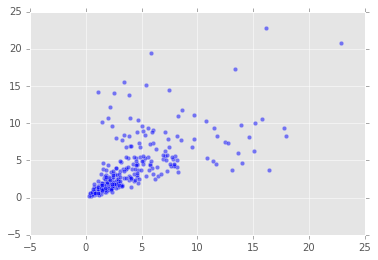

In [25]:
from numpy import isnan
mbin1_s[0,:]
#plt.hist(mbin[4,:],range=(0.1,1.0),alpha=0.5)
plt.scatter(mbin1,mbin2,alpha=0.5)
#plt.show()

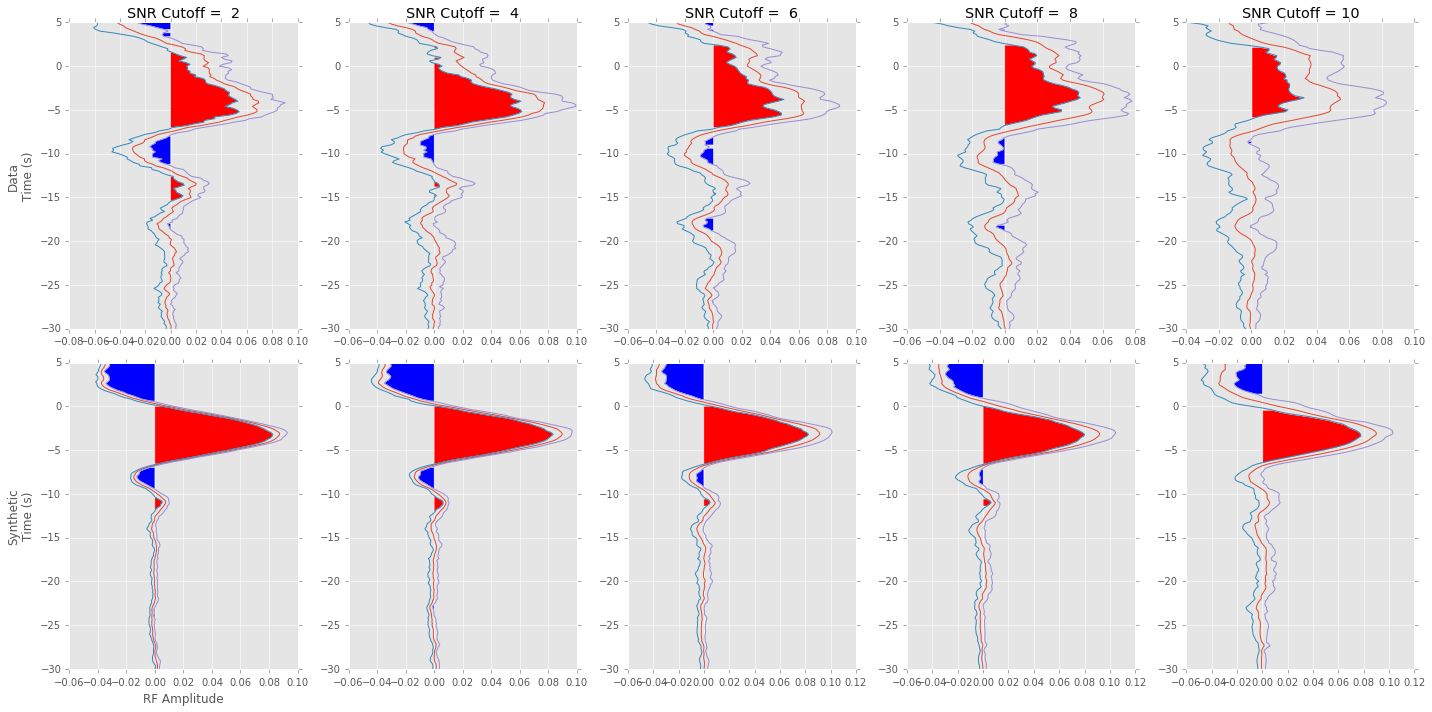

In [26]:
from numpy import nanmean, nanmedian, nanstd
from numpy.random import choice

#times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

#nrfs = len(cat2)
#nrfs = 329

minsnrs = arange(2, 12, 2)

#rbin_sn = rbin_s.copy() + randn(rbin_s.shape[0],rbin_s.shape[1],rbin_s.shape[2])*0.05

for iplt, minsnr in enumerate(minsnrs):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        snr_sample = arange(len(cat2))[mbin2[0,:]>minsnr]
        
        nrfs = len(snr_sample)
        
        rbin1=rbin0[0,snr_sample,:]
        
        nboot = 500

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        for iboot in range(nboot):
            random_sample = choice(range(nrfs), nrfs, replace=True)
            bbin[iboot,:] = nanmedian(rbin1[random_sample,:len(RF)],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(minsnrs),iplt+1)
        else:
            plt.subplot(2,len(minsnrs),iplt+1+len(minsnrs))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        if irow == 0:
            plt.title('SNR Cutoff = %2d' % (minsnr) )

plt.subplot(2,len(minsnrs),1)
plt.ylabel('Data\nTime (s)')
plt.subplot(2,len(minsnrs),1+len(minsnrs))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')

#plt.ylabel('Time (s)')
#plt.xlabel('RF Amplitude')
    
plt.tight_layout()
plt.savefig('FFC_SNR.eps')

In [ ]:
times = arange(len(P))*stis[0].stats.delta
plt.plot(times,P)
stis.plot()

(array([  25.,   57.,   29.,   17.,  241.,   58.,    0.,    0.,  475.,   15.]),
 array([   1.4630011 ,   37.18776826,   72.91253541,  108.63730257,
         144.36206973,  180.08683688,  215.81160404,  251.5363712 ,
         287.26113835,  322.98590551,  358.71067266]),
 <a list of 10 Patch objects>)

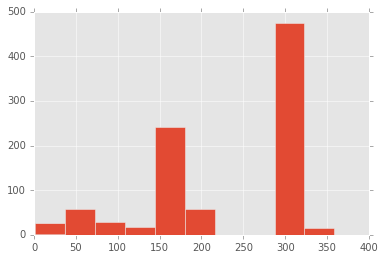

In [27]:
tmp=[]
for ievt, evt in enumerate(cat2):
    elat=evt.preferred_origin().latitude
    elon=evt.preferred_origin().longitude
    edep=evt.preferred_origin().depth/1000.0
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg = delm/1000./111.11
    tmp.append(baz)
    
plt.hist(tmp)

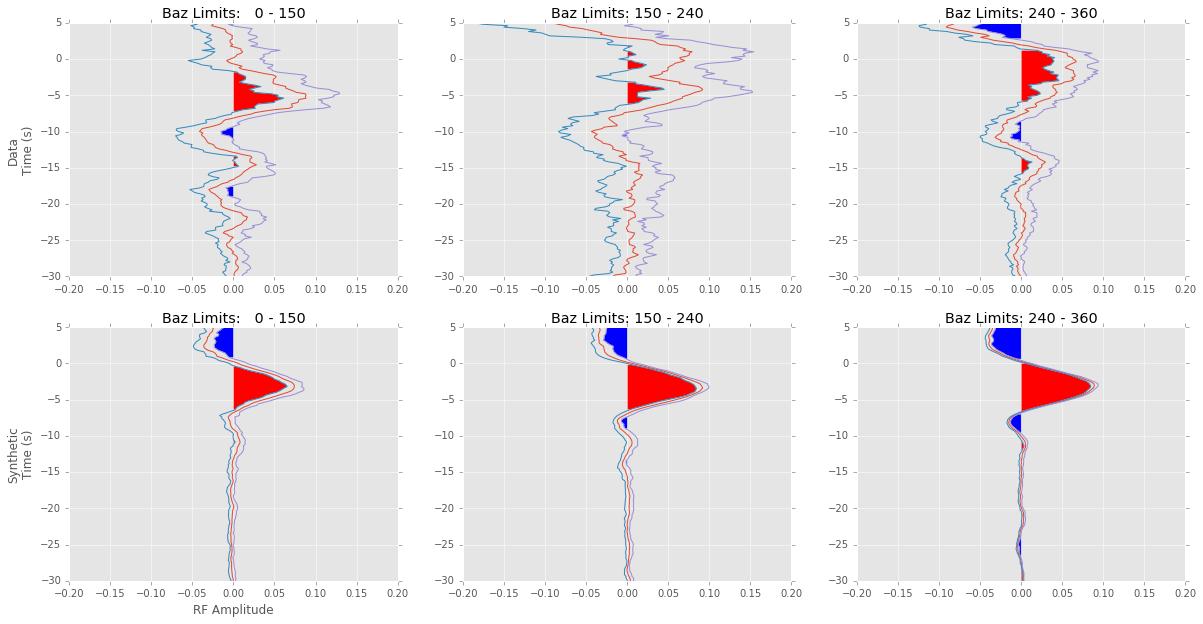

In [32]:
from numpy import nanmean, nanmedian, nanstd, array, shape
from numpy.random import choice

times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)


depthranges = [(0,150),(150,240),(240,360)]

iplt = 4

for iplt, depthrange in enumerate(depthranges):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        dmin, dmax = depthrange[0], depthrange[1]

        slic = array(array(tmp) > dmin) & array(array(tmp) < dmax)

        #print(dmin, dmax, len(slic))

        nboot = 100

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        rbin2 = rbin0[0,slic,:len(RF)]
        nrf,_ = shape(rbin2)

        for iboot in range(nboot):

            random_sample = choice(range(nrf), nrf, replace=True)

            #print(nrf, len(random_sample))

            bbin[iboot,:] = nanmedian(rbin2[random_sample,:],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(depthranges),iplt+1)
        else:
            plt.subplot(2,len(depthranges),iplt+1+len(depthranges))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        plt.xlim(-0.2,0.2)
        plt.title('Baz Limits: %3d - %3d' % (dmin, dmax))

plt.subplot(2,len(depthranges),1)
plt.ylabel('Data\nTime (s)')
        
plt.subplot(2,len(depthranges),1+len(depthranges))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')
    
#plt.tight_layout()
plt.savefig('FFC_baz_limted.eps')